## Heat equation

$$ \frac{\partial T}{\partial t} = d\cdot \frac{\partial^2 T}{x^2} + S(x,t) \newline$$
$$ T(0,t) = \alpha_0 (t) \newline$$
$$ T(L,t) = \alpha_L (t)\newline$$
$$ T(x,0) = \beta (x)\newline$$

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd

In [2]:
# Parameters for the heat equation
N = 100       # Number of spatial grid points
w = np.zeros(N)  # Array to store solutions at spatial grid points
L = 10        # Length of the spatial domain
h = L / (N+1) # Spatial grid spacing
d = 0.1       # Diffusivity coefficient

$$ w` = A \cdot w + b(t) $$

w = \begin{bmatrix}
w_1 (t) \\
w_2 (t) \\
\vdots \\
w_N (t) \\
\end{bmatrix}




A = \frac{d}{h^2} * \begin{bmatrix}
-2 & 1 & 0 & \dots & 0 \\
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 1 & -2 \\
\end{bmatrix}



In [3]:
# Calculating A matrix
A = np.diag([-2]*N) + np.diag([1]*(N-1), 1) + np.diag([1]*(N-1), -1)
A = A * d / h**2
A

array([[-20.402,  10.201,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [ 10.201, -20.402,  10.201, ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,  10.201, -20.402, ...,   0.   ,   0.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ..., -20.402,  10.201,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  10.201, -20.402,  10.201],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,  10.201, -20.402]])

In [4]:
A.shape

(100, 100)

b (t) = \begin{bmatrix}
S (x_1,t) \\
S (x_2,t) \\
\vdots \\
S (x_N,t) \\
\end{bmatrix} + \begin{bmatrix}
\frac{d}{h^2}\alpha_0 (t)  \\
0 \\
\vdots \\
\frac{d}{h^2}\alpha_L (t) \\
\end{bmatrix}

$$w_i (0) = \beta (x_i) \newline$$


In [5]:
# Source
def S(x, t):
    return np.exp(-(x - L/2)**2 / (L/2)) + 1/(t + 1)

# Initial condition
def alpha0(t):
    return 20

# Boundary condition at x = L
def alphaL(t):
    return 100

# Initial condition at t = 0
def beta(x):
    return 300

# Right side of w' = A * w + b(t)
def b(t):
    ret = [S((i+1)*h, t) for i in range(N)]
    ret[0] += d * alpha0(t) / h / h
    ret[-1] += d * alphaL(t) / h / h
    return ret

In [6]:
def F(w, t):
    return np.dot(A, w) + b(t)

dt = 0.02

w0 = np.array([beta((i+1)*h) for i in range(N)])

steps = 10_000
X = np.zeros((steps+1, N))
X[0] = w0

for ts in range(steps):
    X[ts+1] = dt * F(X[ts], ts*dt) + X[ts]

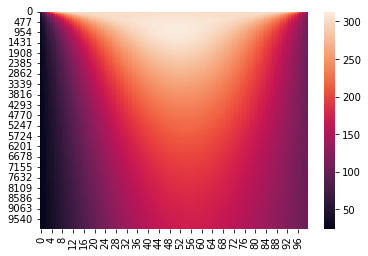

In [7]:
sns.heatmap(X)
plt.show()

### Single Value Decomposition for head equation (How we learned in class)

#### Single Value Decomposition
comp = 4
U,s,Vh = randomized_svd(X.T,n_components=comp,random_state=0)

In [8]:
# Single Value Decomposition for head equation (How we learned in class)
comp = 4
U, s, Vh = randomized_svd(X.T, n_components=comp, random_state=0)

# Check and print information
print("U matrix shape:", U.shape)
print("Singular values:", s)
print("Vh matrix shape:", Vh.shape)


U matrix shape: (100, 4)
Singular values: [187122.30038203  11223.89569294   6928.96844628   2097.37999685]
Vh matrix shape: (4, 10001)


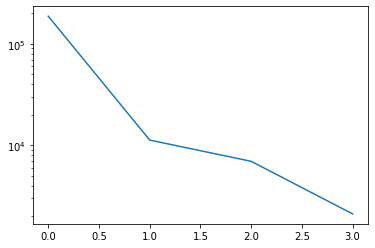

In [9]:
plt.semilogy(s)

<AxesSubplot:>

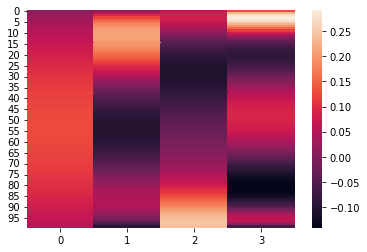

In [10]:
sns.heatmap(U)

### Reduce equation

$$ \alpha´ = A_r \cdot \alpha + b_r \\ \alpha_0 = U_r^T \dot w_0 $$

$$ A_r = U_r^T\cdot A \cdot U_r $$

$$ b_r(t) = U_r^T \cdot b(t) $$

#Compose Ar matrix
Ar = U.T @ A @ U
Ar

In [16]:
# computing the SVD
U, s, Vh = np.linalg.svd(X.T)
# the number of components to keep
components_to_keep = 4  # Adjust as needed

# Reduce the matrices using the dominant singular vectors and values
U_r = U[:, :components_to_keep]

In [17]:
Ar = U_r.T @ A @ U_r
Ar

array([[-0.0382271 ,  0.04549913, -0.13601428,  0.01878499],
       [ 0.04549913, -0.207222  ,  0.21012675, -0.13081753],
       [-0.13601428,  0.21012675, -0.68222543, -0.00608469],
       [ 0.01878499, -0.13081753, -0.00608469, -0.5936133 ]])

In [18]:
#Compose br function
def br(t):
    return U_r.T @ b(t)

In [19]:
def Fr(w, t):
    return (np.dot(Ar,w))+br(t)

dt = 0.02

# w0 = np.array([ beta( (i+1)*h ) for i in range(N) ])
wr0 = U_r.T@w0


Xr = np.zeros((steps+1,4))
Xr[0] = wr0
for ts in range(steps):
    Xr[ts+1] = dt*Fr(Xr[ts], ts*dt) + Xr[ts]

In [20]:
Xred=U_r@Xr.T

<AxesSubplot:>

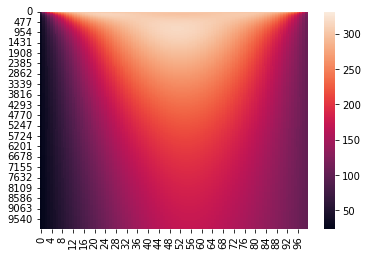

In [21]:
sns.heatmap(Xred.T)

# Project

### Heat equation without reduction the source but separeting it

- Because the source doesn´t depend of the state of the heat in the previus step, 
- it is possible to calculate the source heat independly 
- Here im creating a matrix for the source in position and time

In [22]:
Source_m = np.array([b(ts*dt) for ts in range(steps+1)])
Source_m

array([[2.05028197e+02, 1.00993389e+00, 1.01199116e+00, ...,
        1.01199116e+00, 1.00993389e+00, 1.02110820e+03],
       [2.05008590e+02, 9.90326051e-01, 9.92383313e-01, ...,
        9.92383313e-01, 9.90326051e-01, 1.02108859e+03],
       [2.04989736e+02, 9.71472355e-01, 9.73529617e-01, ...,
        9.73529617e-01, 9.71472355e-01, 1.02106974e+03],
       ...,
       [2.04033173e+02, 1.49100083e-02, 1.69672704e-02, ...,
        1.69672704e-02, 1.49100083e-02, 1.02011317e+03],
       [2.04033173e+02, 1.49095132e-02, 1.69667752e-02, ...,
        1.69667752e-02, 1.49095132e-02, 1.02011317e+03],
       [2.04033173e+02, 1.49090181e-02, 1.69662801e-02, ...,
        1.69662801e-02, 1.49090181e-02, 1.02011317e+03]])

### Reducing the Heat eq (Without reducing the source)

- Changed the profesor code for this part
- In the br(t) function, instead of calculating everytime the b(t), it just checks in the matrix previusly created

#### Single Value Decomposition
comp = 4
U,s,Vh = randomized_svd(X.T,n_components=comp,random_state=0)

#Compose Ar matrix
Ar = U.T @ A @ U
Ar

In [23]:
# computing the SVD
U, s, Vh = np.linalg.svd(X.T)
# the number of components to keep
components_to_keep = 4  # Adjust as needed

# Reduce the matrices using the dominant singular vectors and values
U_r = U[:, :components_to_keep]

In [24]:
#Compose br function
def br(t):
    return U_r.T @ Source_m[t]

def Fr(w, t):
    return (np.dot(Ar,w))+br(t)

dt = 0.02

# w0 = np.array([ beta( (i+1)*h ) for i in range(N) ])
wr0 = U_r.T@w0


Xr = np.zeros((steps+1,4))
Xr[0] = wr0
for ts in range(steps):
    Xr[ts+1] = dt*Fr(Xr[ts], ts) + Xr[ts]

<AxesSubplot:>

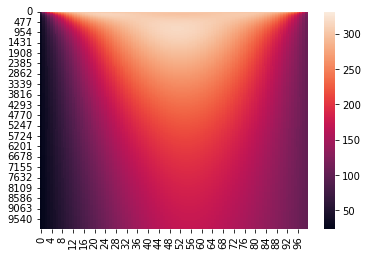

In [25]:
Xred=U_r@Xr.T
sns.heatmap(Xred.T)

- As you can see, the result is the same as the reduction the professor made in class

## Trying to reduce the source and heat equation

### Reducing the source

In [27]:
Source_m = np.array([b(ts*dt) for ts in range(steps+1)])
print(Source_m)

[[2.05028197e+02 1.00993389e+00 1.01199116e+00 ... 1.01199116e+00
  1.00993389e+00 1.02110820e+03]
 [2.05008590e+02 9.90326051e-01 9.92383313e-01 ... 9.92383313e-01
  9.90326051e-01 1.02108859e+03]
 [2.04989736e+02 9.71472355e-01 9.73529617e-01 ... 9.73529617e-01
  9.71472355e-01 1.02106974e+03]
 ...
 [2.04033173e+02 1.49100083e-02 1.69672704e-02 ... 1.69672704e-02
  1.49100083e-02 1.02011317e+03]
 [2.04033173e+02 1.49095132e-02 1.69667752e-02 ... 1.69667752e-02
  1.49095132e-02 1.02011317e+03]
 [2.04033173e+02 1.49090181e-02 1.69662801e-02 ... 1.69662801e-02
  1.49090181e-02 1.02011317e+03]]


- I created the same matrix as before
- But now for each for of the matrix, Im creating a diagonal matrix and applying the SVD
- Then Reducing the source matrix and saving it in the Source_m_red
- Source_m dimentions are Steps x N (this case 10_000, 100)
- Source_m_red dimentions are Steps x comp (this case 10_000, 4)

In [28]:
comp = 4
Source_m_red = np.zeros((steps+1, comp))

for i in range(len(Source_m)):
    # Apply SVD to the diagonal matrix
    U_r, s, Vh = randomized_svd(np.diag(Source_m[i]), n_components=comp, random_state=0)
    
    # Reduce the diagonal matrix using U_r
    Sr = U_r.T @ np.diag(Source_m[i]) @ U_r
    
    # Store the diagonal elements in Source_m_red
    Source_m_red[i] = Sr.diagonal()


### Reducing the Heat eq

In [34]:
# Single Value Decomposition
U_r,s,Vh = randomized_svd(X.T,n_components=comp,random_state=0)

#Compose Ar matrix
Ar = U_r.T @ A @ U_r
Ar

array([[-0.0382271 ,  0.04549913, -0.13601428,  0.01878499],
       [ 0.04549913, -0.207222  ,  0.21012675, -0.13081753],
       [-0.13601428,  0.21012675, -0.68222543, -0.00608469],
       [ 0.01878499, -0.13081753, -0.00608469, -0.5936133 ]])

- In the br(t) fuction I remove the U.T @ Source_m[t] because Source_m_red[t] is already the shape (4,)

In [35]:
#Compose br function
def br(t):
    return  Source_m_red[t]

def Fr(w, t):
    return (np.dot(Ar,w))+br(t)

In [36]:
dt = 0.02

# w0 = np.array([ beta( (i+1)*h ) for i in range(N) ])
wr0 = U_r.T@w0

Xr = np.zeros((steps+1,4))
Xr[0] = wr0
for ts in range(steps):
    Xr[ts+1] = dt*Fr(Xr[ts], ts) + Xr[ts]

In [37]:
Xred=U_r@Xr.T

<AxesSubplot:>

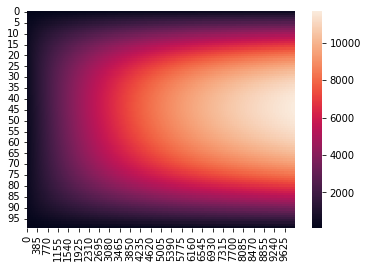

In [38]:
sns.heatmap(Xred)

- As you can see, the result is odd
- It looks like shifted and also the values are way too big